In [144]:
import numpy as np
import torch
import json
import os 
import sys
import subprocess

# Song: "Credits" by Frums, c/f BOFU2015 

cwd = os.getcwd()
song_file = f"{cwd}/../testing_example/audio.mp3"
json_file = f"{cwd}/../testing_example/parsed_extra.json"

with open(json_file,'r') as file:
    parsed = json.loads(file.read())

parsed['offset']

-1267.782124

In [145]:
import soundfile as sf

y, sr = sf.read(song_file)
y = y.mean(axis=1)
print(y.shape)
# offset.
samples_to_replenish = abs(round(parsed['offset']*sr/1000))
y = np.pad(y, (samples_to_replenish,0))
print(y.shape)

(4321406,)
(4377315,)


In [135]:
bpms = parsed['bpms']
mspb = 60000 / bpms[0][1]
print(f"mspb:{mspb} / song duration:{1000*y.shape[0]/sr} / how many beats?: {1000 * y.shape[0]/sr/mspb}")

mspb:335.195530726257 / song duration:99258.84353741497 / how many beats?: 296.12221655328796


In [147]:
# make bpm-dependent melspectrogram.
# hop size shall be mspb / 48
import scipy
hopsize = 1000 * y.shape[0]/sr/mspb/48
fftsize = 256
length_in_beats = 297
# we shouldn't use librosa because it uses integer sample ~s and the error builds up
take_indices = [round((mspb/48) * (sr/1000)*i) for i in range(0,length_in_beats*48)]
y = np.pad(y, (0,round(fftsize+mspb*4*sr/1000)))
take_indices = [[i for i in range(start, start+fftsize)] for start in take_indices]

taken = np.take(y, take_indices)
print(taken.shape)

test_index = 5000
st = take_indices[test_index][0]

# window and take fft, one by one:
fftd = scipy.fft.rfft(taken)
fftd = np.abs(fftd) ** 2
print(fftd.shape)
# we normalize each vector:
reshaper = np.linalg.norm(fftd,axis=1,keepdims=True) + 1e-12 
fftd /= reshaper


# now reshape every 48 * (fftsize//2 + 1)segment into one axis.
# iow we wish to make something of size (297,-1).
# 
fftd_r = np.reshape(fftd, (1,-1))
fftd_r = np.reshape(fftd, (length_in_beats, -1))
print(fftd_r.shape)


(14256, 256)
(14256, 129)
(297, 6192)


In [148]:
import torch
matrix = torch.Tensor(fftd_r).to('cuda')
matrix.shape

b = torch.matmul(matrix, matrix.transpose(1,0))
b.shape

torch.Size([297, 297])

<AxesSubplot: >

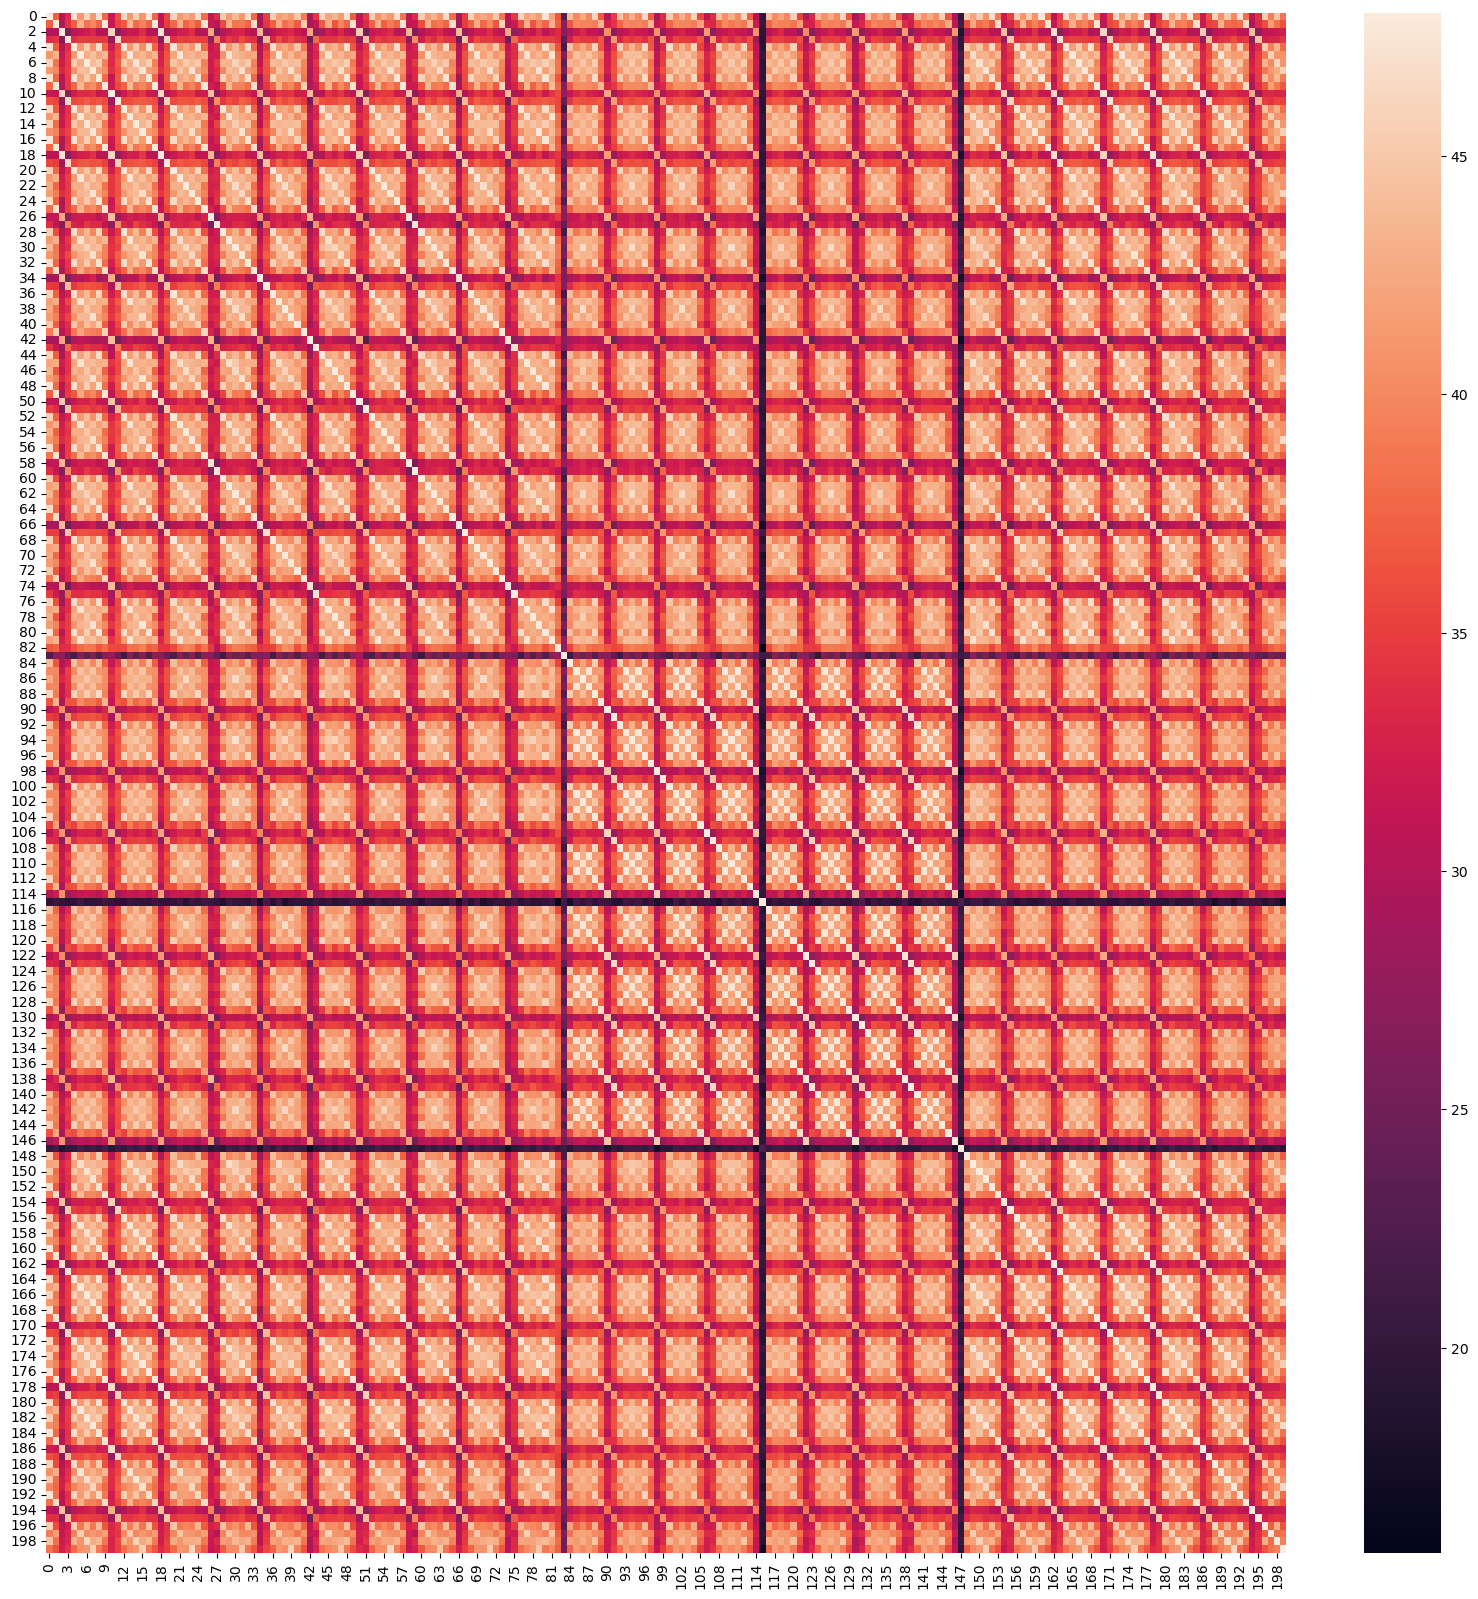

In [150]:
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(b[80:280,80:280].cpu().numpy())

In [1]:
from make_similarity_matrix import make_beatwise_similarity_matrix
soflanchan = "/mnt/c/Users/manym/Desktop/gorst/gorst/osu-to-ddc/test_outputs/strahv/normal.osu.json"
mat = make_beatwise_similarity_matrix(soflanchan)

In [14]:
# for each bar, identify which bars are the most relevant to the parts at hand.
import numpy as np 
which = 100
howmany = 5
ind = np.argpartition(mat[which],-howmany)[-howmany:]
top5 = mat[which][ind]
print(top5)
print(ind)

[0.9197969  0.94596046 0.9665715  0.99999774 0.984465  ]
[389 132 116 100  84]


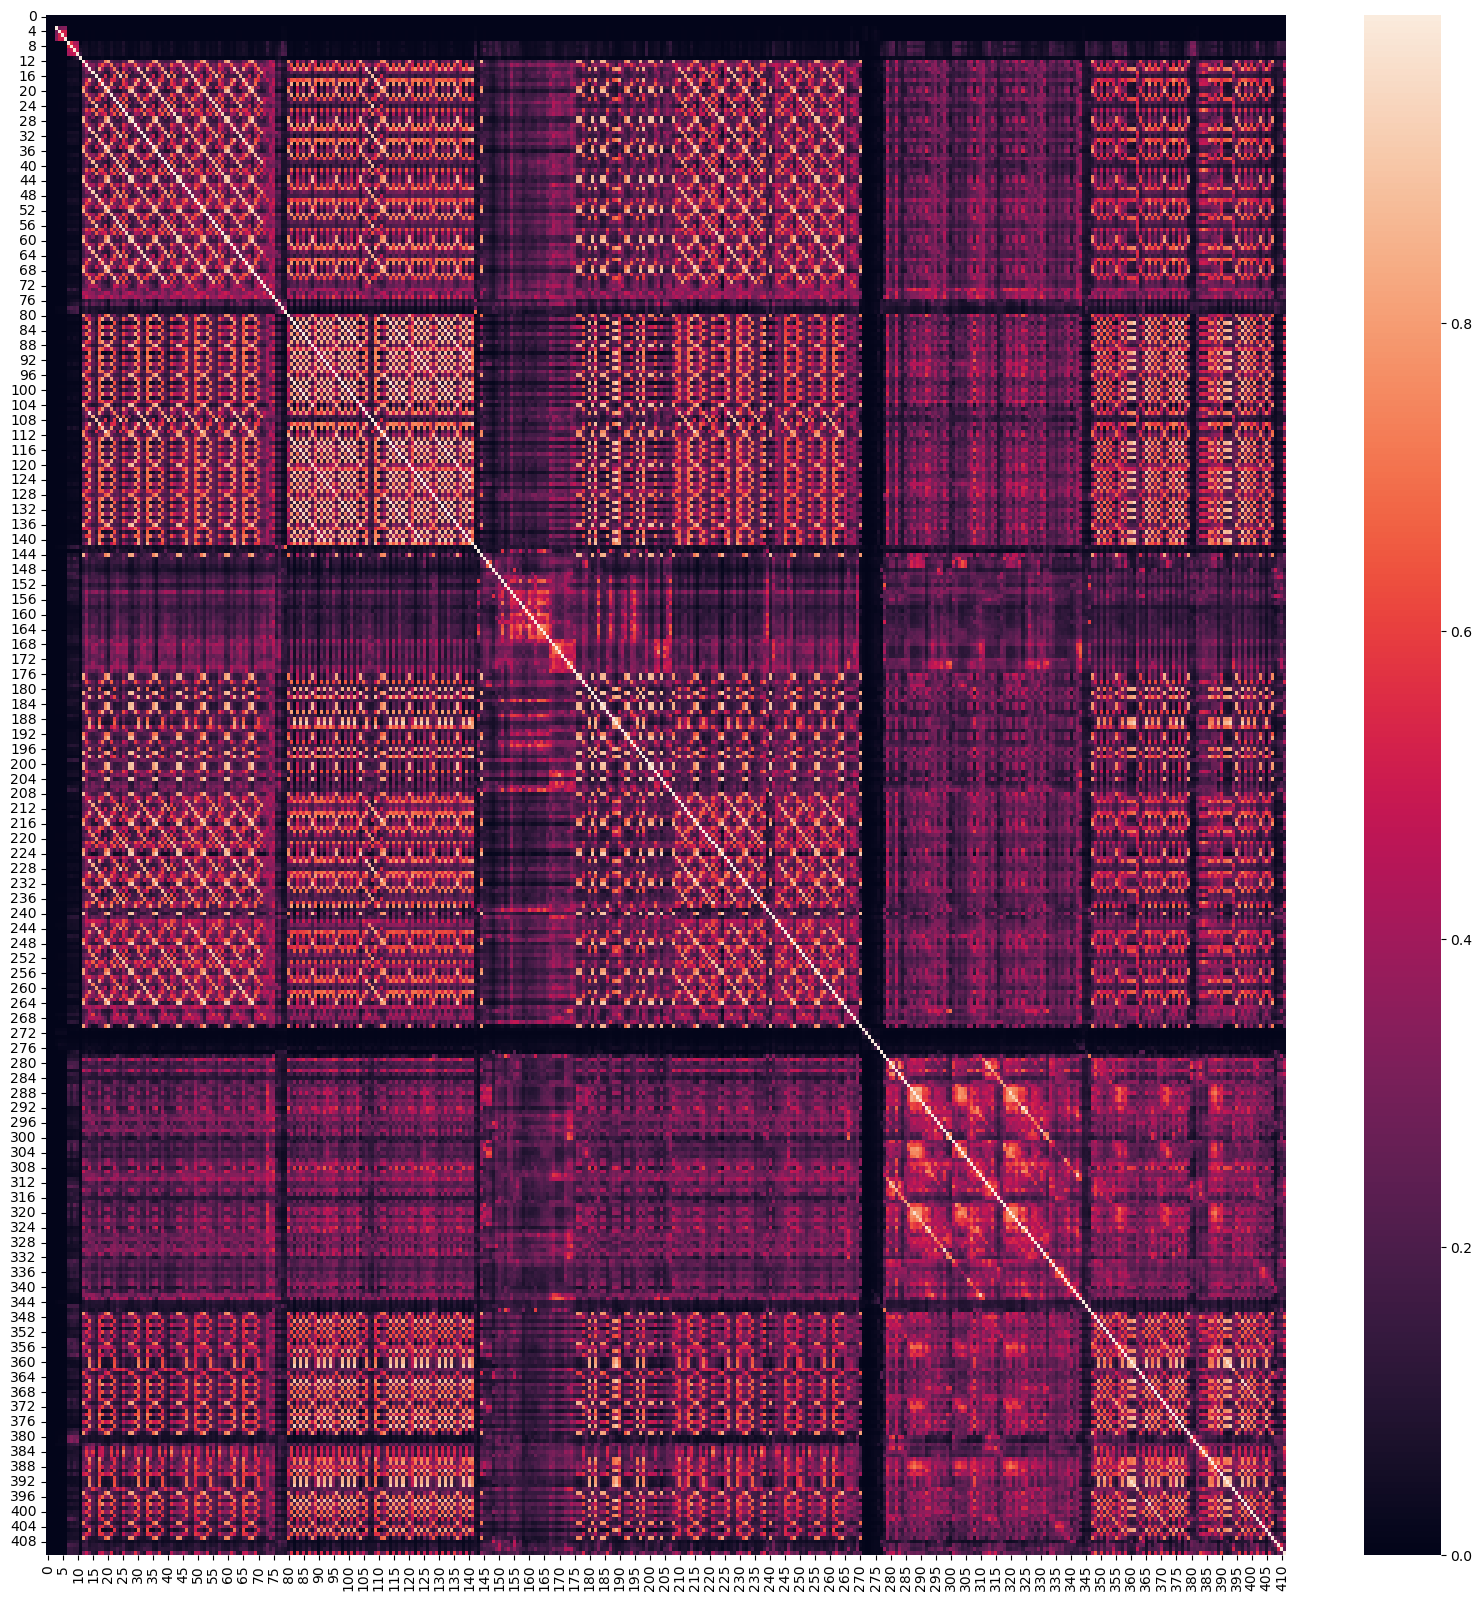

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(mat)
plt.savefig("strahv.png",bbox_inches="tight")
# strahv had its last 30s cut from the chart. the below is correct

14256


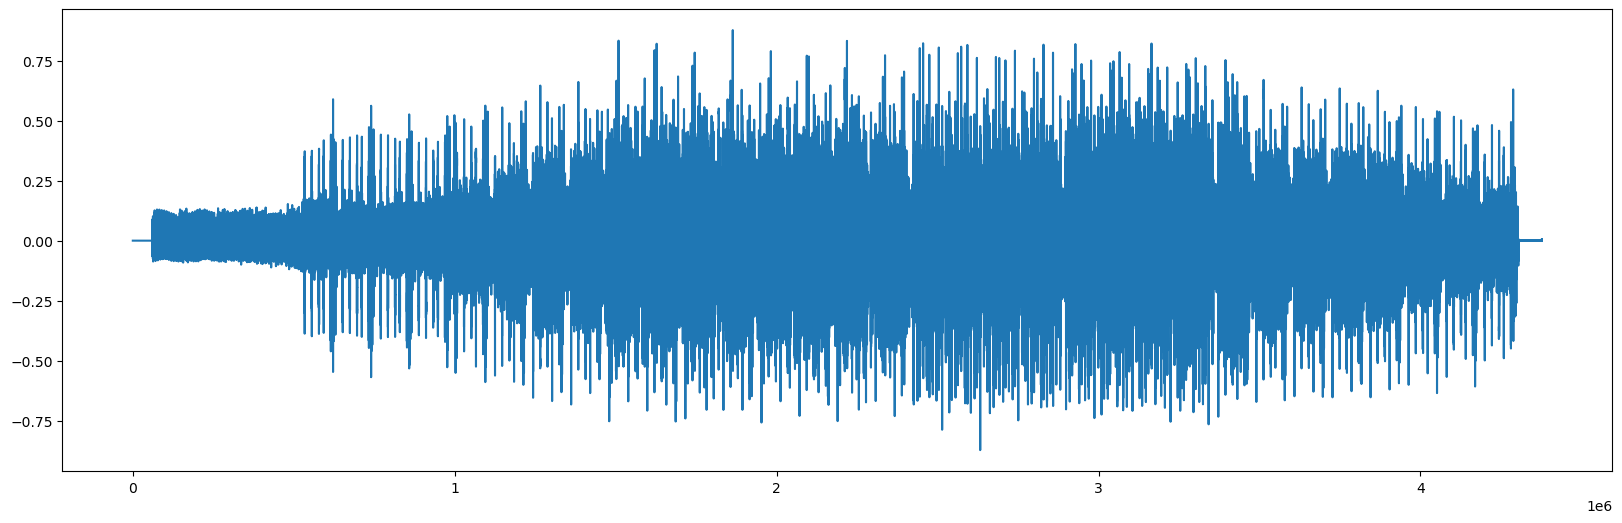

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.plot(y)
print(len(take_indices))